In order to import DEMs (Data Elevation Map) we will need the GDAL library and use some handy functions:

In [2]:
from osgeo import gdal, osr
from pprint import pprint
import numpy as np
import numpy.ma as ma

dataset = gdal.Open('maps/hwmidres.tif')

Information on the map can be obtained from the GetGeoTransform property. There are six entries:
* Most important are the resolutions, index 1 (w-e, or x) and 5 (n-s, or y).
* Index 0 and 3 indicate the top left easting value(or x), and northing value(or y). 
* If the map is north pointing, index 2 and 4 should be **zero**. 

In [3]:
dataset_info = dataset.GetGeoTransform()
resX = dataset_info[1]
resY = dataset_info[5]
print "top left x, or easting value: " + str(dataset_info[0]) 
print "top left y, or northing value: " + str(dataset_info[3]) 
print "w-e pixel resolution: " + str(resX) 
print "n-s pixel resolution: " + str(-resY) 
print 'Driver: ', dataset.GetDriver().ShortName,'/', \
      dataset.GetDriver().LongName
width = dataset.RasterXSize
height = dataset.RasterYSize
minx = dataset_info[0]
miny = dataset_info[3] + width*dataset_info[4] + height*dataset_info[5] 
maxx = dataset_info[0] + width*dataset_info[1] + height*dataset_info[2]
maxy = dataset_info[3] 
print str(minx) + " | " + str(miny) + " | " + str(maxx) + " | "+ str(maxy)

top left x, or easting value: 291557.89307
top left y, or northing value: 4815772.44255
w-e pixel resolution: 0.2
n-s pixel resolution: 0.2
Driver:  GTiff / GeoTIFF
291557.89307 | 4815174.44255 | 292310.09307 | 4815772.44255


Info on the projection type of the map can be obtained from dataset.GetProjection(), and comes in wkt format.

In [4]:
dataset_proj = dataset.GetProjection()
pprint(dataset_proj)
# Should look like this example:
# 'PROJCS["GDA_1994_Transverse_Mercator",
#    GEOGCS["GDA_1994",
#       DATUM["GDA_1994",
#          SPHEROID["GRS_1980",6378137,298.2572221010002],
#          TOWGS84[0,0,0,0,0,0,0]
#       ],
#       PRIMEM["Greenwich",0],
#       UNIT["degree",0.0174532925199433]
#    ],
#    PROJECTION["Transverse_Mercator"],
#    PARAMETER["latitude_of_origin",0],
#    PARAMETER["central_meridian",117],
#    PARAMETER["scale_factor",0.9996],
#    PARAMETER["false_easting",500000],
#    PARAMETER["false_northing",10000000],
#    UNIT["Meter",1]

'PROJCS["WGS 84 / UTM zone 12N",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433],AUTHORITY["EPSG","4326"]],PROJECTION["Transverse_Mercator"],PARAMETER["latitude_of_origin",0],PARAMETER["central_meridian",-111],PARAMETER["scale_factor",0.9996],PARAMETER["false_easting",500000],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AUTHORITY["EPSG","32612"]]'


We can get different parameters from the projection feeding the wkt into osr. SpatialReference, and then using the GetAttrValue

In [5]:
srs = osr.SpatialReference(wkt=dataset_proj)
projcs = srs.GetAttrValue('PROJCS')  # This will be a string that looks something like
projcs

'WGS 84 / UTM zone 12N'

In [6]:
test_string = projcs
zone = int(test_string.split(' ')[-1][0:-1])
zoneLetter = test_string.split(' ')[-1][-1]
print zone
print zoneLetter
print test_string.split(' ')

12
N
['WGS', '84', '/', 'UTM', 'zone', '12N']


Next we want to get the DEM into a data structure we can operate on. We will use numpy arrays because they allow for easy and efficient computation, and because GDAL has a built in function that will do this for us (GetRasterBand combined with ReadAsArray). 

In [7]:
band = dataset.GetRasterBand(1)

ReadAsArray can be called with buf_xsize and buf_ysize to downsample.

In [8]:
arr = band.ReadAsArray()
uniques = np.unique(arr)
pprint(uniques.size)


296672


We can access the size of the "pixel" map in several ways:

In [9]:
print "x -> " +  str(dataset.RasterXSize) + ", y | " + str(dataset.RasterYSize)
print "rows: " + str(arr.shape[0]) + ", cols: " + str(arr.shape[1])

x -> 3761, y | 2990
rows: 2990, cols: 3761


In [10]:
dataset.RasterCount

1

In [11]:
narr = ma.masked_array(arr, mask=arr<0)
narr = narr.filled(narr.mean())
uniques = np.unique(narr)
pprint(uniques.size)
pprint(narr)


296671
array([[ 1795.34301758,  1795.34301758,  1795.34301758, ...,
         1795.34301758,  1795.34301758,  1795.34301758],
       [ 1795.34301758,  1795.34301758,  1795.34301758, ...,
         1795.34301758,  1795.34301758,  1795.34301758],
       [ 1795.34301758,  1795.34301758,  1795.34301758, ...,
         1795.34301758,  1795.34301758,  1795.34301758],
       ..., 
       [ 1795.34301758,  1795.34301758,  1795.34301758, ...,
         1795.34301758,  1795.34301758,  1795.34301758],
       [ 1795.34301758,  1795.34301758,  1795.34301758, ...,
         1795.34301758,  1795.34301758,  1795.34301758],
       [ 1795.34301758,  1795.34301758,  1795.34301758, ...,
         1795.34301758,  1795.34301758,  1795.34301758]], dtype=float32)


In [12]:
import matplotlib.pyplot as plt
%matplotlib inline
def plot_map(narr):
    narr_zeroed = narr-narr.min()
    narr_norm = narr_zeroed / narr_zeroed.max()
    narr_img = np.uint8(plt.cm.viridis(narr_norm)*255) #cmap = 'viridis'
    return narr_img

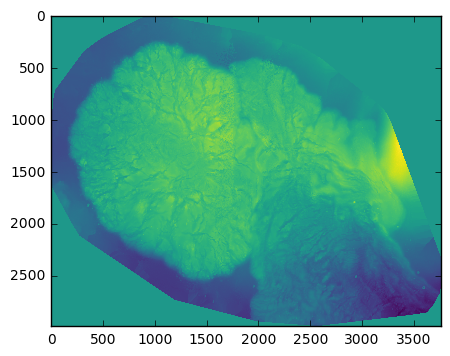

In [13]:
plt.imshow(plot_map(narr))

In [14]:
import json
import geojson
from shapely.geometry import mapping, shape, Polygon, MultiPoint
import shapely.wkt as wkt

In [15]:
import pandas as pd
pd.options.display.max_rows = 5

with open('MD10_EVA10_Stn18_Stn23_X.json') as data_file:    
    data = json.load(data_file)
ways_and_segments = data['sequence']
s = pd.DataFrame(ways_and_segments)
waypoints = s[s['type']=='Station']['geometry']
w = waypoints.values.tolist()
latlongFull = pd.DataFrame(w)
latlongInter = latlongFull['coordinates'].values.tolist()
latlong = pd.DataFrame(latlongInter, columns=['longitude','latitude'])
latlong

,longitude,latitude
0,-113.572019,43.461621
1,-113.571818,43.462455
...,...,...
9,-113.573593,43.463636
10,-113.574050,43.463874


In [16]:
path_min_lat, path_min_long = latlong[['latitude','longitude']].min()
print(path_min_lat, path_min_long)
path_max_lat, path_max_long = latlong[['latitude','longitude']].max()
print(path_max_lat, path_max_long)
top_left = (path_min_long, path_min_lat)
bottom_left =(path_min_long, path_max_lat)
bottom_right = (path_max_long, path_max_lat)
top_right = (path_max_long, path_min_lat)

polyNY_shapely = Polygon([(top_left), (bottom_left), (bottom_right), (top_right)])
g1 = wkt.loads(polyNY_shapely.wkt)
g1f = geojson.Feature(geometry=g1)

(43.461620743164517, -113.57405009999999)
(43.463874099999998, -113.5715867181881)


In [17]:
coordinates = latlong.values
coordinates_shapely = MultiPoint(coordinates)
g2 = wkt.loads(coordinates_shapely.wkt)
g2f = geojson.Feature(geometry=g2)

In [18]:
from geojson import FeatureCollection

features = FeatureCollection([g1f, g2f])

In [19]:
import folium
map_osm = folium.Map(location=[43.459764136666699, -113.574385796667], tiles='Stamen Terrain',
           zoom_start=13)

for cc in coordinates:
    folium.Marker(cc[::-1], popup='point '+str(cc), icon=folium.Icon(icon='cloud')).add_to(map_osm) 
    
folium.GeoJson(
g1f,
style_function=lambda feature: {
    'fillColor': '#ffff00',
    'color' : 'blue',
    'weight' : 2
    }).add_to(map_osm)

map_osm;

In [20]:
from pyproj import Proj
from pyproj import transform
zone = "12T"
p1 = Proj(proj='utm', zone=zone, datum='WGS84')
p2 = Proj(proj='latlong', zone=zone, datum='WGS84')
min_lon, min_lat = transform(p1, p2, minx, miny)
max_lon, max_lat = transform(p1, p2, maxx, maxy)

def latlong2px(longlat):
    long = longlat[0]
    lat = longlat[1]
    (UTMx, UTMy) = p1(long, lat)
    px_x = int((UTMx - minx)/(maxx - minx)*dataset.RasterXSize)
    px_y = int((UTMy - miny)/(maxy - miny)*dataset.RasterYSize)
    return (px_x, px_y)

In [21]:
from pyproj import Proj
from pyproj import transform
zone = "12T"
p1 = Proj(proj='utm', zone=zone, datum='WGS84')
p2 = Proj(proj='latlong', zone=zone, datum='WGS84')
min_lon, min_lat = transform(p1, p2, minx, miny)
max_lon, max_lat = transform(p1, p2, maxx, maxy)

path_min_long_lat = (path_min_long, path_min_lat)
path_max_long_lat = (path_max_long, path_max_lat)
(path_minx, path_miny) = latlong2px(path_min_long_lat)
(path_maxx, path_maxy) = latlong2px(path_max_long_lat)

print(path_minx, path_miny)
print(path_maxx, path_maxy)

(1045, 616)
(2080, 1836)


In [22]:
pprint(coordinates)

(coordinates[:,0].min(),coordinates[:,1].min())

array([[-113.57201854,   43.46162074],
       [-113.57181845,   43.46245467],
       [-113.57158672,   43.46283157],
       [-113.57174616,   43.46295182],
       [-113.57174874,   43.46319999],
       [-113.57189094,   43.46317908],
       [-113.57219385,   43.46329632],
       [-113.57266771,   43.46331013],
       [-113.57305409,   43.46330418],
       [-113.5735927 ,   43.4636355 ],
       [-113.5740501 ,   43.4638741 ]])


(-113.57405009999999, 43.461620743164517)

In [23]:
path_minx, path_miny = (pathxy[:,0].min(), pathxy[:,1].min())
path_maxx, path_maxy = (pathxy[:,0].max(), pathxy[:,1].max())

pathxy = np.apply_along_axis(latlong2px, 1, coordinates)
pathxy_shift = pathxy;
pathxy_shift[:,0] = pathxy[:,0]-path_minx;
pathxy_shift[:,1] = pathxy[:,1]-path_miny;

pprint(pathxy)
print(path_minx, path_miny)
print(path_maxx, path_maxy)

NameError: name 'pathxy' is not defined

In [ ]:
cropped_image = narr[path_miny:path_maxy,path_minx:path_maxx]
plt.imshow(plot_map(cropped_image))
plt.scatter(pathxy_shift[:,0],path_maxy-path_miny-pathxy_shift[:,1],s=100)

In [ ]:
plt.imshow(plot_map(narr))

In [ ]:
from ipywidgets import interact
from bokeh.io import push_notebook, show, output_notebook
from bokeh.plotting import figure
output_notebook()



In [ ]:
dh, dw = cropped_image.shape
print dw,dh

In [ ]:
%time
# create a new plot with a title and axis labels
p = figure(title="simple line example", x_axis_label='x', y_axis_label='y')

# add a line renderer with legend and line thickness
p.image(image=[cropped_image[::-1,:]], dw=dw, dh=dh, palette="Spectral11")
p.circle(pathxy_shift[:,0], pathxy_shift[:,1])

# show the results
t = show(p, notebook_handle=True)
%time

In [ ]:
print(min_lon, min_lat)
print(max_lon, max_lat)

In [ ]:
#map_osm.add_children(folium.plugins.ImageOverlay(cropped_image, opacity=0.8, \
#       bounds =[[min_lat, min_lon], [max_lat, max_lon]]))